<a href="https://colab.research.google.com/github/rishabhprashr/Coursera_Capstone/blob/master/battle_of_neighborhoods5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
USA is a large and ethnically diverse country. Its largest city New York has a long history of international immigration. Asians, Europeans,Africans,etc make up a large amount of this population and New York is at the centre of it. Cultural diversity brings along a difference of preferences ,opinions,background and tastes. Our goal here is ananlyzing the diversity and popularity of restaurants in the neighborhoods of New York to come up with a business strategy and the most suitable neighborhood to establish the business among all the given neighborhoods. We will use Foursquare places API to find out venues and explore the neighborhoods and scrape out details in a given radius. Our goal here is finding the popular cuisines of different neigborhoods to establish a fusion style restaurant catering to different tastes of multi ethnic population in a diverse neighborhood.

#Data
We will require the neighborhood data of New York along with their location in latitudes and longitudes.The Neighborhoods in NY has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

We will use this freely availabel dataset on the internet: https://geo.nyu.edu/catalog/nyu_2451_34572

The dataset contains details of location of different neighborhoods under the given boroughs in json format. We transform the json to a pandas dataframe. We now have a pandas dataframe containing the location data of all the neighborhoods. We define a Foursquare API URI containing the 
credentials to make requests for the given neighborhoods using the locations of the given neighborhoods. We define and transform the dataframes to select the features of our requirements. We find the top 3 popular cuisines of each neighborhoods and then combine the dataset to find the most popular cuisines overall for a fusion restaurant.

For example while making an API call to explore the surroundings of a given neighborhood,we will collect the top venues and segregate them based upon the cuisines in a given radius around the neighborhood and make a similar dataset for all the neighborhoods.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

print('Libraries imported.')

Matplotlib version:  3.2.1
Libraries imported.


In [0]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)


In [0]:
neighborhoods_data = newyork_data['features']


In [4]:
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

Empty DataFrame
Columns: [Borough, Neighborhood, Latitude, Longitude]
Index: []

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)
neighborhoods['Borough']

The dataframe has 5 boroughs and 306 neighborhoods.


0              Bronx
1              Bronx
2              Bronx
3              Bronx
4              Bronx
5              Bronx
6          Manhattan
7              Bronx
8              Bronx
9              Bronx
10             Bronx
11             Bronx
12             Bronx
13             Bronx
14             Bronx
15             Bronx
16             Bronx
17             Bronx
18             Bronx
19             Bronx
20             Bronx
21             Bronx
22             Bronx
23             Bronx
24             Bronx
25             Bronx
26             Bronx
27             Bronx
28             Bronx
29             Bronx
30             Bronx
31             Bronx
32             Bronx
33             Bronx
34             Bronx
35             Bronx
36             Bronx
37             Bronx
38             Bronx
39             Bronx
40             Bronx
41             Bronx
42             Bronx
43             Bronx
44             Bronx
45             Bronx
46          Brooklyn
47          B

In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [57]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
 
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 
    
map_newyork

In [125]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20200609' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [126]:
LIMIT = 200 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/search?categoryId=4d4b7105d754a06374d81259&client_id=&client_secret=&v=20200609&ll=40.7127281,-74.0060152&radius=1000&limit=200'

In [0]:
results = requests.get(url).json()


In [0]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
results

{'meta': {'code': 200, 'requestId': '5ee0af55f3317b21abc7c8a3'},
 'response': {'confident': False,
  'venues': [{'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/taco_',
       'suffix': '.png'},
      'id': '4bf58dd8d48988d151941735',
      'name': 'Taco Place',
      'pluralName': 'Taco Places',
      'primary': True,
      'shortName': 'Tacos'}],
    'hasPerk': False,
    'id': '5d5f24ec09484500079aee00',
    'location': {'address': '136 Church St',
     'cc': 'US',
     'city': 'New York',
     'country': 'United States',
     'distance': 287,
     'formattedAddress': ['136 Church St',
      'New York, NY 10007',
      'United States'],
     'labeledLatLngs': [{'label': 'display',
       'lat': 40.714267,
       'lng': -74.008756}],
     'lat': 40.714267,
     'lng': -74.008756,
     'postalCode': '10007',
     'state': 'NY'},
    'name': 'Los Tacos No. 1',
    'referralId': 'v-1591783349'},
   {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net

In [0]:
def get_category_id(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['id']

In [16]:
venues = results['response']['venues']
k=json_normalize(venues)
filt_columns = ['id','name', 'categories', 'location.lat', 'location.lng']
k_venues =k.loc[:, filt_columns]
k_venues['place categories'] = k_venues.apply(get_category_id, axis=1)
k_venues['categories'] = k_venues.apply(get_category_type, axis=1)
k_venues.columns = [col.split(".")[-1] for col in k_venues.columns]

k_venues



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


id                               name  \
0   5d5f24ec09484500079aee00                    Los Tacos No. 1   
1   5c6f03f30802d4002c16884c                        Joe’s Pizza   
2   49ccd495f964a52091591fe3                         Kaffe 1668   
3   5d39f3d5052ad00008304116                  Taco Bell Cantina   
4   4a56a32ff964a52090b51fe3                Jubilee Marketplace   
5   5d754979ea4bf40007c080c4          Tonii’s Fresh Rice Noodle   
6   4b0c402af964a520c33923e3            Stage Door Delicatessen   
7   4ea0afbf9adf1e334e4cc0e6          Laughing Man Coffee & Tea   
8   5ded51eaf492de00080966ed                 Joe's Shanghai 鹿嗚春   
9   4b7de017f964a52049d82fe3                          Starbucks   
10  4afd9156f964a520a82822e3                        Burger King   
11  4c43890cfb6eb713c1304e4a                   55 Fulton Market   
12  5dba113267232c000803cb37           For Five Coffee Roasters   
13  4a59f31df964a52095b91fe3                       Leo's Bagels   
14  58ab3a6a53f5bb4b6b267ad1                  City Acres Market   
15  577c4a4a498e2c214c8f57e1                         sweetgreen   
16  5a91cf271de7652a1150d942                            Alimama   
17  5787b68e498efcabbebba4f8                        Shake Shack   
18  5d7c220a72c409000888c908                        Tiger Sugar   
19  49f220a3f964a520ee691fe3                 Nom Wah Tea Parlor   
20  574456e5498e39c73d234da1               Black Fox Coffee Co.   
21  3fd66200f964a520b1ea1ee3              Great N.Y. Noodletown   
22  4b342e93f964a520dd2525e3          Popeyes Louisiana Kitchen   
23  4f3046da7beb0cfa14dcac59      Taïm Falafel and Smoothie Bar   
24  3fd66200f964a520ede41ee3                   Big Wong King 大旺   
25  5362a2ae498e3b18c22334be                        Hudson Eats   
26  4de3e4effa7651589f21983d                      Mother's Ruin   
27  3fd66200f964a52093ea1ee3                             Nyonya   
28  5b9686e7d807ee002c498f8d                       Golden Diner   
29  579c12cd498e6e815b3acf50                    Eataly Downtown   
30  5d7d2f62774999000703bdcb             Yin Ji Chang Fen 銀記腸粉店   
31  57bf76a2498e98061d338fe3                      Café Integral   
32  55148c66498e987ed9d8e394                        Le District   
33  431e2d80f964a52079271fe3                         La Esquina   
34  5008a087e4b034274e2743d8                      Little Rascal   
35  5d8e37f352f64b000873b779                              Zooba   
36  5a8b235f340a5831027daa58                   Bake Culture USA   
37  49eb223ff964a520a6661fe3                  Tai Pan Bakery 大班   
38  5cf62af9cb3fd2002c8e8a4c                               CAVA   
39  4cd37295baf2f04dfc22afa3  Cha Chan Tang 茶餐廳 (Cha Chan Tang)   
40  40c10d00f964a520dd001fe3                        Ruby's Café   
41  49bd4d49f964a52065541fe3              Banh Mi Saigon Bakery   
42  5a387ba8838e597257b20ed7           Roman And Williams GUILD   
43  57583641498e90001a32e13e                          Le Coucou   
44  4c7d4f1b8da18cfa1afc9ece                     Osteria Morini   
45  4d34caa4c75a6ea84a9522ae              Merchants River House   
46  519393ce498edf62feac9c12                      Watermark Bar   
47  55387c1b498e4eca6482f4f5                   Industry Kitchen   
48  4a01ee7bf964a52010711fe3                      P.J. Clarke's   
49  59d828f0916bc1155fde2c04                           Hwa Yuan   

                  categories        lat        lng          place categories  
0                 Taco Place  40.714267 -74.008756  4bf58dd8d48988d151941735  
1                Pizza Place  40.710318 -74.007694  4bf58dd8d48988d1ca941735  
2                Coffee Shop  40.715045 -74.011509  4bf58dd8d48988d1e0931735  
3                 Taco Place  40.708428 -74.004985  4bf58dd8d48988d151941735  
4              Grocery Store  40.708241 -74.006468  4bf58dd8d48988d118951735  
5         Chinese Restaurant  40.715671 -73.999074  4bf58dd8d48988d145941735  
6             Sandwich Place  40.711796 -74.010027  4bf

In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&categoryId=4d4b7105d754a06374d81259&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
manhattan_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [19]:
ny_venues=manhattan_venues
ny_venues.shape

(10469, 7)

In [0]:
ny_venues.to_csv('ny_d')

In [21]:
#grouping based on neighborhood to find the top diverse neighborhoods based on food category

top5=ny_venues.groupby('Neighborhood')['Venue Category'].nunique().reset_index()
top5.sort_values(['Venue Category'], ascending=False, axis=0, inplace=True)
top5=top5.head().reset_index(drop=True)
top5.head()






Neighborhood  Venue Category
0  Fort Greene              35
1  Murray Hill              35
2  Boerum Hill              33
3   South Side              33
4      Chelsea              32

In [58]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


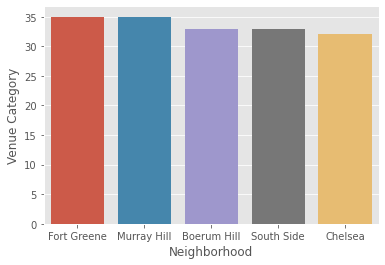

In [59]:

sns.barplot(x="Neighborhood", y="Venue Category", data=top5)

In [23]:
# one hot encoding
ny_onehot = pd.get_dummies(ny_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0    Wakefield                  0                   0                    0   
1    Wakefield                  0                   0                    0   
2    Wakefield                  0                   0                    0   
3    Wakefield                  0                   0                    0   
4    Wakefield                  0                   0                    0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  \
0       0                 0                       0            0   
1       0                 0                       0            0   
2       0                 0                       0            0   
3       0                 0                       0            0   
4       0                 0                       0            0   

   Asian Restaurant  Australian Restaurant  Austrian Restaurant  BBQ Joint  \
0                 0                      0                    0          0   
1                 0                      0                    0          0   
2                 0                      0                    0          0   
3                 0                      0                    0          0   
4                 0                      0                    0          0   

   Bagel Shop  Bakery  Bar  Beer Bar  Beer Garden  Beer Store  \
0           0       0    0         0            0           0   
1           0       0    0         0            0           0   
2           0       0    0         0            0           0   
3           0       0    0         0            0           0   
4           0       0    0         0            0           0   

   Belgian Restaurant  Bike Shop  Bistro  Boat or Ferry  Bowling Alley  \
0                   0          0       0              0              0   
1                   0          0       0              0              0   
2                   0          0       0              0              0   
3                   0          0       0              0              0   
4                   0          0       0              0              0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bubble Tea Shop  Buffet  \
0                     0               0        0                0       0   
1                     0               0        0                0       0   
2                     0               0        0                0       0   
3                     0               0        0                0       0   
4                     0               0        0                0       0   

   Building  Burger Joint  Burrito Place  Butcher  Cafeteria  Café  \
0         0             0              0        0          0     0   
1         0             0              0        0          0     0   
2         0             0              0        0          0     0   
3         0             0              0        0          0     0   
4         0             0              0        0          0     0   

   Cajun / Creole Restaurant  Cambodian Restaurant  Candy Store  \
0                          0                     0            0   
1                          0                     0            0   
2                          0                     0            0   
3                          0                     0            0   
4                          0                     0            0   

   Cantonese Restaurant  Caribbean Restaurant  Caucasian Restaurant  \
0                     0                     0                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     0   
4                     0                     0                     0   

   Cha Chaan Teng  Cheese Shop  Chinese Restaurant  Chocolate Shop  \
0               0            0     

# New Section

In [24]:
ny_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

                                     Venue  Venue Latitude  Venue Longitude  \
0                              Pitman Deli       40.896744       -73.844398   
1                         Lollipops Gelato       40.894123       -73.845892   
2  Cooler Runnings Jamaican Restaurant Inc       40.898083       -73.850259   
3                         Carvel Ice Cream       40.890487       -73.848568   
4                             Chef Central       40.891625       -73.844531   

         Venue Category  
0                  Food  
1          Dessert Shop  
2  Caribbean Restaurant  
3        Ice Cream Shop  
4                 Diner

In [25]:
ny_onehot.shape

(10469, 201)

In [26]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

Neighborhood  Afghan Restaurant  African Restaurant  \
0                     Allerton           0.000000            0.000000   
1                     Annadale           0.000000            0.000000   
2                Arden Heights           0.000000            0.000000   
3                    Arlington           0.000000            0.000000   
4                     Arrochar           0.000000            0.000000   
5                      Arverne           0.000000            0.000000   
6                      Astoria           0.000000            0.000000   
7              Astoria Heights           0.000000            0.000000   
8                   Auburndale           0.021277            0.000000   
9                   Bath Beach           0.000000            0.000000   
10           Battery Park City           0.000000            0.000000   
11                   Bay Ridge           0.000000            0.000000   
12                 Bay Terrace           0.000000            0.000000   
13                  Baychester           0.000000            0.000000   
14                     Bayside           0.000000            0.000000   
15                Bedford Park           0.000000            0.000000   
16          Bedford Stuyvesant           0.000000            0.000000   
17                  Beechhurst           0.000000            0.000000   
18                    Bellaire           0.000000            0.000000   
19                Belle Harbor           0.000000            0.000000   
20                   Bellerose           0.000000            0.000000   
21                     Belmont           0.000000            0.000000   
22                 Bensonhurst           0.000000            0.000000   
23                Bergen Beach           0.000000            0.000000   
24                  Blissville           0.000000            0.000000   
25                 Boerum Hill           0.000000            0.000000   
26                Borough Park           0.000000            0.000000   
27                Breezy Point           0.000000            0.000000   
28                   Briarwood           0.000000            0.000000   
29              Brighton Beach           0.000000            0.000000   
30               Broad Channel           0.000000            0.000000   
31           Broadway Junction           0.000000            0.000000   
32                   Bronxdale           0.000000            0.000000   
33            Brooklyn Heights           0.000000            0.000000   
34                  Brookville           0.000000            0.000000   
35                 Brownsville           0.000000            0.000000   
36                  Bulls Head           0.000000            0.000000   
37                    Bushwick           0.000000            0.020000   
38                Butler Manor           0.000000            0.000000   
39             Cambria Heights           0.000000            0.000000   
40                    Canarsie           0.000000            0.029412   
41               Carnegie Hill           0.000000            0.000000   
42             Carroll Gardens           0.000000            0.000000   
43                 Castle Hill           0.000000            0.000000   
44           Castleton Corners           0.000000            0.000000   
45              Central Harlem           0.000000            0.040816   
46                  Charleston           0.000000            0.000000   
47                     Chelsea           0.000000            0.000000   
48                   Chinatown           0.000000            0.000000   
49                 City Island           0.000000            0.000000   
50                   City Line           0.000000            0.000000   
51                Civic Center           0.000000            0.000000   
52           Claremont Village           0.000000            0.048780   
53                Clason Point           0.000000            0.000000   
54 

In [27]:
ny_grouped.shape

(297, 201)

In [28]:
num_top_venues = 5

for hood in ny_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ny_grouped[ny_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0       Deli / Bodega  0.20
1         Pizza Place  0.16
2  Chinese Restaurant  0.09
3                Food  0.07
4  Mexican Restaurant  0.07


----Annadale----
                 venue  freq
0          Pizza Place  0.32
1  American Restaurant  0.16
2           Restaurant  0.11
3               Bakery  0.11
4           Bagel Shop  0.11


----Arden Heights----
               venue  freq
0      Deli / Bodega  0.25
1        Pizza Place  0.25
2        Coffee Shop  0.25
3               Food  0.25
4  Afghan Restaurant  0.00


----Arlington----
                  venue  freq
0   American Restaurant  0.29
1         Deli / Bodega  0.14
2  Caribbean Restaurant  0.14
3           Pizza Place  0.14
4           Coffee Shop  0.14


----Arrochar----
           venue  freq
0  Deli / Bodega  0.20
1    Pizza Place  0.13
2           Food  0.10
3     Food Truck  0.10
4     Restaurant  0.07


----Arverne----
                venue  freq
0      Sandwich Place  0.27
1    

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ny_venues_sorted = pd.DataFrame(columns=columns)
ny_venues_sorted['Neighborhood'] = ny_grouped['Neighborhood']

for ind in np.arange(ny_grouped.shape[0]):
    ny_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_grouped.iloc[ind, :], num_top_venues)

ny_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton         Deli / Bodega           Pizza Place   
1       Annadale           Pizza Place   American Restaurant   
2  Arden Heights           Pizza Place                  Food   
3      Arlington   American Restaurant           Pizza Place   
4       Arrochar         Deli / Bodega           Pizza Place   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0    Chinese Restaurant                  Food    Mexican Restaurant  
1            Restaurant                Bakery            Bagel Shop  
2         Deli / Bodega           Coffee Shop           Wings Joint  
3  Caribbean Restaurant         Deli / Bodega   Peruvian Restaurant  
4                  Food            Food Truck            Bagel Shop

In [37]:
# set number of clusters
kclusters = 5

ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([2, 0, 2, 0, 2], dtype=int32)

In [38]:
# add clustering labels
ny_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_merged = ny_merged.join(ny_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ny_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             1.0   
1   Bronx   Co-op City  40.874294 -73.829939             2.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             0.0   
4   Bronx    Riverdale  40.890834 -73.912585             0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Food         Deli / Bodega           Pizza Place   
1         Deli / Bodega  Fast Food Restaurant           Pizza Place   
2  Caribbean Restaurant         Deli / Bodega  Fast Food Restaurant   
3  Fast Food Restaurant     German Restaurant           Wings Joint   
4           Pizza Place    Italian Restaurant         Deli / Bodega   

         4th Most Common Venue 5th Most Common Venue  
0                   Donut Shop  Caribbean Restaurant  
1                   Restaurant    Chinese Restaurant  
2                        Diner           Pizza Place  
3  Eastern European Restaurant     Fish & Chips Shop  
4          Japanese Restaurant    Mexican Restaurant

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



In [50]:
ny_merged.dropna(inplace=True)
ny_merged.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             1.0   
1   Bronx   Co-op City  40.874294 -73.829939             2.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             0.0   
4   Bronx    Riverdale  40.890834 -73.912585             0.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                  Food         Deli / Bodega           Pizza Place   
1         Deli / Bodega  Fast Food Restaurant           Pizza Place   
2  Caribbean Restaurant         Deli / Bodega  Fast Food Restaurant   
3  Fast Food Restaurant     German Restaurant           Wings Joint   
4           Pizza Place    Italian Restaurant         Deli / Bodega   

         4th Most Common Venue 5th Most Common Venue  
0                   Donut Shop  Caribbean Restaurant  
1                   Restaurant    Chinese Restaurant  
2                        Diner           Pizza Place  
3  Eastern European Restaurant     Fish & Chips Shop  
4          Japanese Restaurant    Mexican Restaurant

In [51]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color= rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We start analyzing the cluster to find the most frequent occuring places in top 5 common venues. Then we add the most frequnt venues to our final set for analysis.


In [111]:
cl1=ny_merged.loc[ny_merged['Cluster Labels'] == 0, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
cl1.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
3    Fieldston  Fast Food Restaurant     German Restaurant   
4    Riverdale           Pizza Place    Italian Restaurant   
5  Kingsbridge           Pizza Place         Deli / Bodega   
6  Marble Hill         Deli / Bodega            Donut Shop   
8      Norwood           Pizza Place    Chinese Restaurant   

  3rd Most Common Venue        4th Most Common Venue  \
3           Wings Joint  Eastern European Restaurant   
4         Deli / Bodega          Japanese Restaurant   
5            Donut Shop                       Bakery   
6   American Restaurant                       Bakery   
8                Bakery          Fried Chicken Joint   

       5th Most Common Venue  
3          Fish & Chips Shop  
4         Mexican Restaurant  
5       Fast Food Restaurant  
6                       Food  
8  Latin American Restaurant

In [0]:
#we use a dataframe to start adding the most popular entries.
lcat=pd.Dataframe()

In [87]:
#grouping based on neighborhood to find the top diverse neighborhoods based on food category

top3=cl1[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].mode()
lcat[0]=top3.T
lcat


0
1st Most Common Venue  Coffee Shop
2nd Most Common Venue  Pizza Place
3rd Most Common Venue       Bakery
4th Most Common Venue  Pizza Place
5th Most Common Venue   Donut Shop

In [113]:
cl2=ny_merged.loc[ny_merged['Cluster Labels'] == 1, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
cl2.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0        Wakefield                  Food         Deli / Bodega   
2      Eastchester  Caribbean Restaurant         Deli / Bodega   
9   Williamsbridge  Caribbean Restaurant           Pizza Place   
25      Morrisania    Chinese Restaurant  Caribbean Restaurant   
41       Olinville         Deli / Bodega  Caribbean Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0            Pizza Place            Donut Shop  Caribbean Restaurant  
2   Fast Food Restaurant                 Diner           Pizza Place  
9          Deli / Bodega                Bakery                  Food  
25  Fast Food Restaurant                  Food                Bakery  
41                  Food   Fried Chicken Joint                Bakery

In [91]:
top3=cl2[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].mode()
lcat[1]=top3.T
lcat

0                     1
1st Most Common Venue  Coffee Shop  Caribbean Restaurant
2nd Most Common Venue  Pizza Place         Deli / Bodega
3rd Most Common Venue       Bakery    Chinese Restaurant
4th Most Common Venue  Pizza Place                  Food
5th Most Common Venue   Donut Shop                  Food

In [115]:
cl3=ny_merged.loc[ny_merged['Cluster Labels'] == 2, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
cl3.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
1           Co-op City         Deli / Bodega  Fast Food Restaurant   
7             Woodlawn         Deli / Bodega           Pizza Place   
11      Pelham Parkway         Deli / Bodega           Pizza Place   
13        Bedford Park         Deli / Bodega    Mexican Restaurant   
14  University Heights         Deli / Bodega    Chinese Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
1            Pizza Place            Restaurant    Chinese Restaurant  
7                   Café            Food Truck                Bakery  
11                  Café                 Diner        Sandwich Place  
13    Chinese Restaurant                 Diner           Pizza Place  
14                  Food   Fried Chicken Joint                Bakery

In [93]:
top3=cl3[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].mode()
lcat[2]=top3.T
lcat

0                     1                   2
1st Most Common Venue  Coffee Shop  Caribbean Restaurant       Deli / Bodega
2nd Most Common Venue  Pizza Place         Deli / Bodega         Pizza Place
3rd Most Common Venue       Bakery    Chinese Restaurant  Chinese Restaurant
4th Most Common Venue  Pizza Place                  Food         Pizza Place
5th Most Common Venue   Donut Shop                  Food                Food

In [105]:
cl4=ny_merged.loc[ny_merged['Cluster Labels'] == 3, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
cl4.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
212       Oakwood             BBQ Joint           Wings Joint   
238  Butler Manor     Convenience Store             BBQ Joint   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
212   Egyptian Restaurant           Fish Market     Fish & Chips Shop  
238           Wings Joint   Egyptian Restaurant           Fish Market

In [98]:
top3=cl4[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].mode()
lcat[3]=top3.T[0]
lcat

0                     1                   2  \
1st Most Common Venue  Coffee Shop  Caribbean Restaurant       Deli / Bodega   
2nd Most Common Venue  Pizza Place         Deli / Bodega         Pizza Place   
3rd Most Common Venue       Bakery    Chinese Restaurant  Chinese Restaurant   
4th Most Common Venue  Pizza Place                  Food         Pizza Place   
5th Most Common Venue   Donut Shop                  Food                Food   

                                         3  
1st Most Common Venue            BBQ Joint  
2nd Most Common Venue            BBQ Joint  
3rd Most Common Venue  Egyptian Restaurant  
4th Most Common Venue  Egyptian Restaurant  
5th Most Common Venue    Fish & Chips Shop

In [100]:
cl5=ny_merged.loc[ny_merged['Cluster Labels'] == 4, ny_merged.columns[[1] + list(range(5, ny_merged.shape[1]))]]
cl5.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
217      Tottenville    Italian Restaurant   American Restaurant   
257     Howland Hook    Italian Restaurant           Wings Joint   
287      Egbertville    Italian Restaurant            Bagel Shop   
292  Lighthouse Hill                Bakery                  Café   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
217         Deli / Bodega                 Diner      Asian Restaurant  
257   Egyptian Restaurant     Fish & Chips Shop   Filipino Restaurant  
287           Wings Joint   Empanada Restaurant           Fish Market  
292    Italian Restaurant           Flea Market     Fish & Chips Shop

In [103]:
top3=cl5[['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].mode()
lcat[4]=top3.T[0]
lcat


0                     1                   2  \
1st Most Common Venue  Coffee Shop  Caribbean Restaurant       Deli / Bodega   
2nd Most Common Venue  Pizza Place         Deli / Bodega         Pizza Place   
3rd Most Common Venue       Bakery    Chinese Restaurant  Chinese Restaurant   
4th Most Common Venue  Pizza Place                  Food         Pizza Place   
5th Most Common Venue   Donut Shop                  Food                Food   

                                         3                    4  
1st Most Common Venue            BBQ Joint   Italian Restaurant  
2nd Most Common Venue            BBQ Joint  American Restaurant  
3rd Most Common Venue  Egyptian Restaurant        Deli / Bodega  
4th Most Common Venue  Egyptian Restaurant                Diner  
5th Most Common Venue    Fish & Chips Shop     Asian Restaurant


#Result
We collected a lot of data and made API calls using FourSquare API. There were 306 neighborhoods in New York and only categorically API calls were made so that we could refine our data set. More than 9000 results were found which goes on to show that for a single city that is a lot of opportunity in this space. Our previous analysis showed the top neighborhoods in terms of food category diversity. Then we go on to make a dataset containing the location of venues along with their categories. However to refine our results further ,only the top most 5 popular places of each location was chosen and one-hot encoding was done. We cluster our datasets and then plot it on a folium map.  After all the collection of venues around the neighborhoods of New York and subsequent cleanings and clustering, here is our top five common venues among the five clusters we designed.




In [109]:
lcat

0                     1                   2  \
1st Most Common Venue  Coffee Shop  Caribbean Restaurant       Deli / Bodega   
2nd Most Common Venue  Pizza Place         Deli / Bodega         Pizza Place   
3rd Most Common Venue       Bakery    Chinese Restaurant  Chinese Restaurant   
4th Most Common Venue  Pizza Place                  Food         Pizza Place   
5th Most Common Venue   Donut Shop                  Food                Food   

                                         3                    4  
1st Most Common Venue            BBQ Joint   Italian Restaurant  
2nd Most Common Venue            BBQ Joint  American Restaurant  
3rd Most Common Venue  Egyptian Restaurant        Deli / Bodega  
4th Most Common Venue  Egyptian Restaurant                Diner  
5th Most Common Venue    Fish & Chips Shop     Asian Restaurant

#Conclusion
Our final results show that their is a clear diversity in tastes resulting due to multi ethnicity. Our analysis before showed that Fort Greene and Murray Hill are the most diverse categorically, so ideally they can be the best place for a diverse group of people to offer a fusion restaurant.Next we do a exploratory analyis to see in which clusters our neighborhoods lie.

In [123]:
nei=cl1[cl1['Neighborhood']=='Murray Hill']

nei


Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
115  Murray Hill     Korean Restaurant           Coffee Shop   
180  Murray Hill     Korean Restaurant           Coffee Shop   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
115         Deli / Bodega            Donut Shop           Pizza Place  
180         Deli / Bodega            Donut Shop           Pizza Place

In [124]:
nei1=cl1[cl1['Neighborhood']=='Fort Greene']
nei1

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
69  Fort Greene    Italian Restaurant         Deli / Bodega   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
69           Coffee Shop                  Café           Pizza Place

We can see that both the neighborhoods lie in cluster 1. So we now have a dataset of most common foods categories across all the neighborhhods in New York and we know the neighborhoods which are delved in diversity the most.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.

For a better view of notebook: https://nbviewer.jupyter.org/github/rishabhprashr/Coursera_Capstone/blob/master/battle_of_neighborhoods5.ipynb